In [1]:
import torch
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import time
from AA import pytorchAA, numpyAA
from problems import quad2, quad1
from numpy import linalg as LA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rcParams.update({'font.size': 14})
def_colors=(plt.rcParams['axes.prop_cycle'].by_key()['color'])
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
def simgd(problem, x0, y0, k, lr, maxiter, type2 = False):
    loss = problem.loss(x0, y0)
    lossalt=[]
    lossalt.append(loss)
    x, y = x0, y0
    for i in range( maxiter):
        gx, gy = problem.grad(x, y)
        x = x - lr * gx
        y = y + lr * gy
        lo = problem.loss(x, y)
        lossalt.append(lo)    
    return lossalt


def altgd(problem, x0, y0, k, lr, maxiter, type2 = False):
    loss = problem.loss(x0, y0)
    lossalt=[]
    lossalt.append(loss)
    x, y = x0, y0
    for i in range( maxiter):
        gx, _ = problem.grad(x, y)
        x = x - lr * gx
        _, gy = problem.grad(x, y)
        y = y + lr * gy
        lo = problem.loss(x, y)
        lossalt.append(lo)    
    return lossalt

def eg(problem, x0, y0, k, lr, maxiter, type2 = False):
    loss = problem.loss(x0, y0)
    losseg = []
    losseg.append(loss)
    x, y = x0, y0
    for i in range( maxiter):
        gx, gy = problem.grad(x, y)
        x_ = x - lr * gx
        y_ = y + lr * gy
        gx, gy = problem.grad(x_, y_)
        x = x - lr * gx
        y = y + lr * gy
        lo = problem.loss(x, y)
        losseg.append(lo)    
    return losseg


def omd(problem, x0, y0, k, lr, maxiter, type2 = False):
    loss = problem.loss(x0, y0)
    lossomd=[]
    lossomd.append(loss)
    x, y = x0, y0
    x_l, y_l = 0.5*x0, 0.5*y0
    g_xl, g_yl = problem.grad(x_l,y_l)
    for i in range(maxiter):
        g_x, g_y = problem.grad(x,y)
        x = x - 2 * lr * g_x + lr * g_xl
        y = y + 2 * lr * g_y - lr * g_yl
        g_xl, g_yl =  g_x, g_y
        lo = problem.loss(x, y)
        lossomd.append(lo)    
    return lossomd


def altAA(problem, x, y, k, lr, maxiter, type2 = False, reg=1e-9):
    loss = problem.loss(x0, y0)
    lossAA=[]
    lossAA.append(loss)
    x, y = x0, y0
    aa_wrk = numpyAA(2*n, k, type2=type2, reg=reg)
    print(aa_wrk.apply)
    fp = np.vstack((x, y))
    converged = False
    for i in range(maxiter):
        fpprev = np.copy(fp)      
        gx, _ = problem.grad(x, y)
        x_ = x - lr * gx
        _, gy = problem.grad(x_, y)
        y_ = y + lr * gy
        fp = np.vstack((x_, y_))
        fp = aa_wrk.apply(fpprev, fp) 
        x, y = fp[0:n],fp[n:] 
        lo = problem.loss(x, y)
        lossAA.append(lo)   
    return lossAA


def simAA(problem, x, y, k, lr, maxiter, type2 = False, reg=1e-8):
    loss = problem.loss(x0, y0)
    lossAA=[]
    lossAA.append(loss)
    x, y = x0, y0
    aa_wrk = numpyAA(2*n, k, type2=type2, reg=reg)
    print(aa_wrk.apply)
    fp = np.vstack((x, y))
    for i in range(maxiter):
        fpprev = np.copy(fp)      
        gx, gy = problem.grad(x, y)
        x_ =  x - lr * gx
        y_ = y + lr * gy
        fp = np.vstack((x_, y_))
        fp = aa_wrk.apply(fpprev, fp) 
        x, y = fp[0:n], fp[n:]
        lo = problem.loss(x, y)
        lossAA.append(lo)   
        if i %k ==0:
            aa_wrk = numpyAA(2*n, k, type2=type2, reg=reg)
    return lossAA

Run simple bilinear example $x^TAy, A(SPD)$

In [3]:
k = 100
n = 100
cond = 5
maxiter = 500
problem = quad1(n, cond,spd=True, bc=False)
x0 = np.random.rand(n,1)
y0 = np.random.rand(n,1)
losssimgd = simgd(problem, x0, y0, k, 0.02, maxiter, True)
lossaltgd = altgd(problem, x0, y0, k, 0.1, maxiter, True)
losseg = eg(problem, x0, y0, k, 0.2, maxiter, True)
lossomd = omd(problem, x0, y0, k, 0.1, maxiter, True)
lossSimAA = simAA(problem, x0, y0, k, 0.4, maxiter, True)
lossaltAA = altAA(problem, x0, y0, k, 0.4, maxiter, True)

spd
bc zeros
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021E96DADE20>>
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021EEF729B80>>


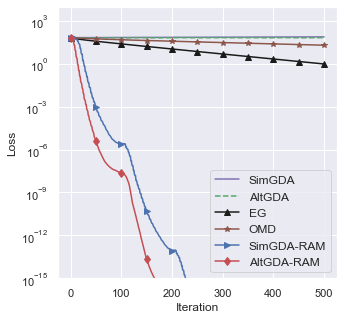

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
markevery = 50
ax.semilogy(losssimgd, 'm-', label='SimGDA',markevery=markevery)
ax.semilogy(lossaltgd, 'g--',label='AltGDA',markevery=markevery)
ax.semilogy(losseg, 'k-^', label='EG',markevery=markevery)
ax.semilogy(lossomd, '-*', color=def_colors[5], label='OMD',markevery=markevery)
ax.semilogy(lossSimAA, 'b->',label='SimGDA-RAM',markevery=markevery)
ax.semilogy(lossaltAA, 'r-d',label='AltGDA-RAM',markevery=markevery)
ax.set_ylim([1e-15,1e4])
ax.legend(loc=4, fontsize=12)
ax.set_xlabel('Iteration',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
fig.savefig('figures/biprob1a.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

Run simple bilinear example $x^TAy, A(normal)$

In [5]:
k = 150
n = 100
cond = 10
maxiter = 1000
problem = quad1(n, cond,spd=False, bc=False)
x0 = np.random.rand(n,1)
y0 = np.random.rand(n,1)
losssimgd = simgd(problem, x0, y0, k, 0.05, maxiter, True)
lossaltgd = altgd(problem, x0, y0, k, 0.05, maxiter, True)
losseg = eg(problem, x0, y0, k, 0.05, maxiter, True)
lossomd = omd(problem, x0, y0, k, 0.02, maxiter, True)
lossSimAA = simAA(problem, x0, y0, 350, 0.1, maxiter, True)
lossaltAA = altAA(problem, x0, y0, k, 0.1, maxiter, True)

random
bc zeros
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021EA115DF10>>
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021EA10DA4F0>>


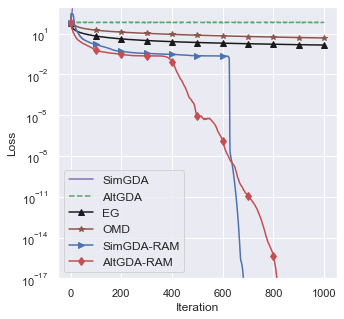

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
markevery = 100
ax.semilogy(losssimgd, 'm-', label='SimGDA',markevery=markevery)
ax.semilogy(lossaltgd, 'g--',label='AltGDA',markevery=markevery)
ax.semilogy(losseg, 'k-^', label='EG',markevery=markevery)
ax.semilogy(lossomd, '-*', color=def_colors[5], label='OMD',markevery=markevery)
ax.semilogy(lossSimAA, 'b->',label='SimGDA-RAM',markevery=markevery)
ax.semilogy(lossaltAA, 'r-d',label='AltGDA-RAM',markevery=markevery)
ax.set_ylim([1e-17,1e3])
ax.legend(loc=3, fontsize=12)
ax.set_xlabel('Iteration',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
fig.savefig('figures/biprob1b.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

Run simple bilinear example $x^TAy + bx + cy, A(normal)$

In [7]:
k = 125
n = 100
cond = 10
maxiter = 1000
problem = quad1(n, cond, spd=False, bc=True)
x0 = np.random.rand(n,1)
y0 = np.random.rand(n,1)
losssimgd = simgd(problem, x0, y0, k, 0.001, maxiter, True)
lossaltgd = altgd(problem, x0, y0, k, 0.01, maxiter, True)
losseg = eg(problem, x0, y0, k, 0.03, maxiter, True)
lossomd = omd(problem, x0, y0, k, 0.01, maxiter, True)
lossSimAA = simAA(problem, x0, y0, 200, 0.2, maxiter, True)
lossaltAA = altAA(problem, x0, y0, k, 0.2, maxiter, True)

random
bc
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021EA1161340>>
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021EA115F6D0>>


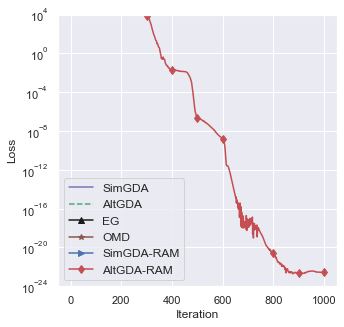

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
markevery = 100
ax.semilogy(losssimgd, 'm-', label='SimGDA',markevery=markevery)
ax.semilogy(lossaltgd, 'g--',label='AltGDA',markevery=markevery)
ax.semilogy(losseg, 'k-^', label='EG',markevery=markevery)
ax.semilogy(lossomd, '-*', color=def_colors[5], label='OMD',markevery=markevery)
ax.semilogy(lossSimAA, 'b->',label='SimGDA-RAM',markevery=markevery)
ax.semilogy(lossaltAA, 'r-d',label='AltGDA-RAM',markevery=markevery)
ax.set_ylim([1e-24,1e4])
ax.set_xlabel('Iteration',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
ax.legend(loc=3, fontsize=12)
fig.savefig('figures/biprob1c.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

Run General Bilinear Problem $x^TAy+B^Tx+C^Ty + x^2 + y^2$

In [9]:
k = 200
lr = 0.3
n = 100
cond = 20
maxiter = 1000
problem = quad2(n, cond, spd=True)

x0 = np.random.rand(n,1)
y0 = np.random.rand(n,1)

losssimgd = simgd(problem, x0, y0, k, 0.001, maxiter, True)
lossaltgd = altgd(problem, x0, y0, k, 0.2, maxiter, True)
losseg = eg(problem, x0, y0, k, 0.2, maxiter, True)
lossomd = omd(problem, x0, y0, k, 0.1, maxiter, True)
lossSimAA = simAA(problem, x0, y0,  150, 0.2, maxiter, True)
lossAltAA = altAA(problem, x0, y0,  k, 0.3, maxiter, True)


<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021E974411C0>>
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021E974414C0>>


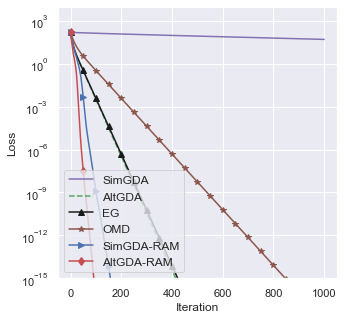

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
markevery = 50
ax.semilogy(losssimgd, 'm-', label='SimGDA',markevery=markevery)
ax.semilogy(lossaltgd, 'g--',label='AltGDA',markevery=markevery)
ax.semilogy(losseg, 'k-^', label='EG',markevery=markevery)
ax.semilogy(lossomd, '-*', color=def_colors[5], label='OMD',markevery=markevery)
ax.semilogy(lossSimAA, 'b->',label='SimGDA-RAM',markevery=markevery)
ax.semilogy(lossAltAA, 'r-d',label='AltGDA-RAM',markevery=markevery)
ax.set_ylim([1e-15,1e4])
ax.legend(loc=3, fontsize=12)
ax.set_xlabel('Iteration',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
fig.savefig('figures/biprob2b.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

In [11]:
k = 200
lr = 0.3
n = 100
cond = 20
maxiter = 500
problem = quad2(n, cond, spd=False)

x0 = np.random.rand(n,1)
y0 = np.random.rand(n,1)

losssimgd = simgd(problem, x0, y0, k, 0.001, maxiter, True)
lossaltgd = altgd(problem, x0, y0, k, 0.02, maxiter, True)
losseg = eg(problem, x0, y0, k, 0.02, maxiter, True)
lossomd = omd(problem, x0, y0, k, 0.01, maxiter, True)
lossSimAA = simAA(problem, x0, y0, 500, 0.15, maxiter, True)
lossAltAA = altAA(problem, x0, y0,  150, 0.15, maxiter, True)

<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021E972AD910>>
<bound method numpyAA.type2 of <AA.numpyAA object at 0x0000021E97261100>>


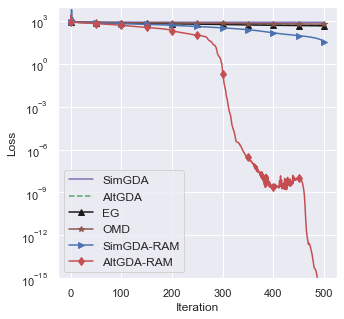

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
markevery = 50
ax.semilogy(losssimgd, 'm-', label='SimGDA',markevery=markevery)
ax.semilogy(lossaltgd, 'g--',label='AltGDA',markevery=markevery)
ax.semilogy(losseg, 'k-^', label='EG',markevery=markevery)
ax.semilogy(lossomd, '-*', color=def_colors[5], label='OMD',markevery=markevery)
ax.semilogy(lossSimAA, 'b->',label='SimGDA-RAM',markevery=markevery)
ax.semilogy(lossAltAA, 'r-d',label='AltGDA-RAM',markevery=markevery)
ax.set_ylim([1e-15,1e4])
ax.legend(loc=3, fontsize=12)
ax.set_xlabel('Iteration',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
fig.savefig('figures/biprob2c.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
